# NLP Disaster Tweets RNN Model by Marshall Folkman

## Problem Description

The problem this Kaggle competition poses is the automatic identification and classification of real-time disaster-related tweets from a sea of everyday communications. With the proliferation of social media and the immediacy of information transmission it offers, agencies such as disaster relief organizations and news agencies aim to leverage this platform for effective disaster management. However, the challenge lies in distinguishing tweets that are truly about real-world disasters from those that use disaster-related language metaphorically. Participants are tasked with building a machine learning model that can discern between these two categories, providing a meaningful way to triage emergency-related communication on Twitter.

The data provided for this task is a collection of 10,000 tweets, split into a training set and a test set, both encompassing the tweet text, a keyword from the tweet (which may be absent), and the tweet's location (which may also be absent). These features form the basis for the machine learning model. The training data additionally includes a target variable, which denotes whether the tweet is about a real disaster (represented by '1') or not (represented by '0'). The ultimate objective of the competition is to make accurate predictions on the test data based on the patterns learned from the training data, thereby determining if a given tweet refers to a genuine disaster or not.

## EDA

In [23]:
# Requires: pip install pandas matplotlib seaborn tensorflow scikit-learn nltk gensim
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
print(sys.version)
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter
import string
import re
import nltk
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import KeyedVectors
from keras.layers import GRU

3.9.17 (main, Jul  5 2023, 20:47:11) [MSC v.1916 64 bit (AMD64)]


In [2]:
# load the google word2vec model
filename = 'D:\OneDrive\_CU-MSEE\AI\DTSA5511_DeepLearning\Week4\GoogleNews-vectors-negative300.bin'  # path to the Word2Vec file
word2vec_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [3]:
train_data = pd.read_csv('D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/Week4/nlp-getting-started/train.csv')
test_data = pd.read_csv('D:/OneDrive/_CU-MSEE/AI/DTSA5511_DeepLearning/Week4/nlp-getting-started/test.csv')
print(train_data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [4]:
# Show a summary of the DataFrame
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [5]:
# Show statistics of the numerical columns
print(train_data.describe())

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


In [6]:
# Count of unique values in each column
for column in train_data.columns:
    print(f"{column}: {train_data[column].nunique()} unique values")

id: 7613 unique values
keyword: 221 unique values
location: 3341 unique values
text: 7503 unique values
target: 2 unique values


In [7]:
# Show any missing values
print(train_data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


target
0    4342
1    3271
Name: count, dtype: int64


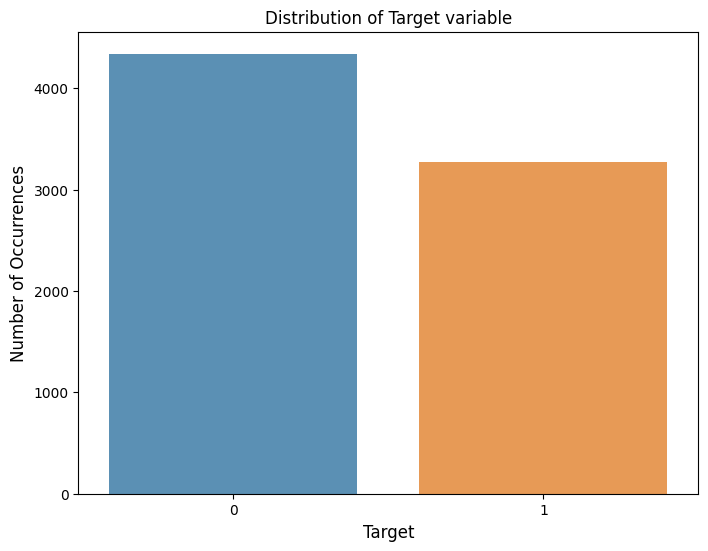

In [8]:
# Count the number of each target class
target_counts = train_data['target'].value_counts()
print(target_counts)

# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=target_counts.index, y=target_counts.values, alpha=0.8)
plt.title('Distribution of Target variable')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.show()

This 'target' imbalance is not extreme so it's less likely that bias will be an issue, but its off enough to keep it in mind.

At this juncture, it is pretty obvious that I will need to use a RNN architecture such as LSTM or GRU. Lets gather more data to help us decide which would be a better use model for this dataset. Then, we'll start preparing the data specifically for that model. Both LSTM and GRU are designed to handle long sequences, but if most of the sentences are short, then the simpler GRU might perform just as well and train faster.

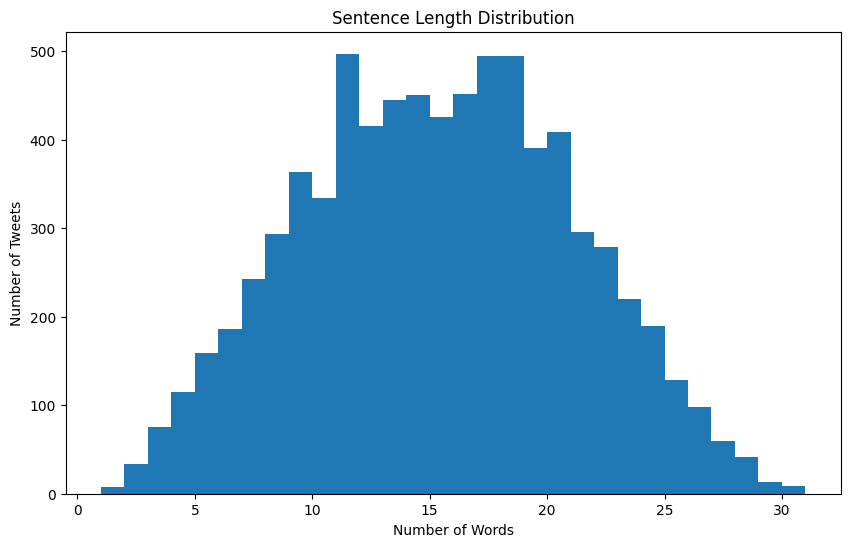

In [9]:
# Analyze sentence length
train_data['text_length'] = train_data['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(train_data['text_length'], bins=30)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.show()

The normal-like distribution of the sentence lengths suggests there isn't an extreme bias towards very short or very long sentences. This is important because we need to get an idea of how to set our maximum sequence length and understand the computational complexity of training this model. Considering the observed range of tweet lengths and the subjects studied, I've determined that starting with an LSTM model would be beneficial. LSTM, or Long Short-Term Memory networks, are a form of RNN that excel at learning from data that exhibit long-term dependencies, a characteristic common in text data. Furthermore, LSTMs are known to handle the vanishing gradient problem more efficiently than vanilla RNNs.

Now, lets get a better idea of how this data should be best cleaned in the next step.

In [10]:
# Count occurrences of each word
word_counts = Counter()
train_data['text'].str.split().apply(word_counts.update)

# Most common words
print("Most common words:", word_counts.most_common(10))

# Least common words
print("Least common words:", word_counts.most_common()[:-10:-1])

Most common words: [('the', 2575), ('a', 1845), ('to', 1805), ('in', 1757), ('of', 1722), ('and', 1302), ('I', 1197), ('for', 820), ('is', 814), ('on', 773)]
Least common words: [('http://t.co/YmY4rSkQ3d', 1), ('http://t.co/STfMbbZFB5', 1), ('http://t.co/nF4IculOje', 1), ('flip', 1), ('http://t.co/rqKK15uhEY', 1), ('symptoms...', 1), ('developing', 1), ('Forney', 1), ('http://t.co/5ueCmcv2Pk', 1)]


In [11]:
# Assuming 'clean_text' is your column with the cleaned tweet text
# First, we split each tweet into words, creating a list of lists
split_tweets = train_data['text'].str.split()

# Then, we flatten the list of lists into a single list containing all words
all_words = [word for tweet in split_tweets for word in tweet]

# Now we use Counter to count unique words
word_counts = Counter(all_words)

# The total number of unique words is the length of this Counter object
num_unique_words_before_cleaning = len(word_counts)

print(f"Number of unique words before cleaning: {num_unique_words_before_cleaning}")

Number of unique words before cleaning: 31924


From this we can see that we will need to remove our 'outliers' during our cleaning process. Specifically I will need to remove things like 'Stopwords', punctuation, numbers, and non-alphabetic characters as these are very often seen throughout the dataset and don't add meanful value to our model. Then, we will need to also remove the other extreme, words seen only once or a few times as this data doesn't correlate to anything else or very little to other data and therefore doesn't add value. Enough chat, lets get cleaning.

## Cleaning and Preprocessing

### Cleaning

In [12]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from text
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in str(text).split() if word not in stop_words])
    
    # Remove words less than 2 characters
    text = " ".join([word for word in text.split() if len(word) > 2])

    return text

# Apply the cleaning function to both test and training datasets
train_data['text'] = train_data['text'].apply(lambda x: clean_text(x))
test_data['text'] = test_data['text'].apply(lambda x: clean_text(x))

# Count occurrences of each word
word_counts = Counter()
train_data['text'].str.split().apply(word_counts.update)

# Most common words
print("Most common words:", word_counts.most_common(10))

# Least common words
print("Least common words:", word_counts.most_common()[:-10:-1])

# Print number of unique words in text field
print(f"{column}: {train_data[column].nunique()} unique values")

Most common words: [('like', 345), ('amp', 298), ('fire', 250), ('get', 229), ('new', 224), ('via', 220), ('people', 195), ('one', 193), ('news', 192), ('dont', 191)]
Least common words: [('symptoms', 1), ('developing', 1), ('forney', 1), ('9km', 1), ('bathandnortheastsomerset', 1), ('overtaking', 1), ('fatherofthree', 1), ('tnwx', 1), ('explosivespacked', 1)]
target: 2 unique values


In [13]:
# Assuming 'clean_text' is your column with the cleaned tweet text
# First, we split each tweet into words, creating a list of lists
split_tweets = train_data['text'].str.split()

# Then, we flatten the list of lists into a single list containing all words
all_words = [word for tweet in split_tweets for word in tweet]

# Now we use Counter to count unique words
word_counts = Counter(all_words)

# The total number of unique words is the length of this Counter object
num_unique_words_after_cleaning = len(word_counts)

print(f"Number of unique words after cleaning: {num_unique_words_after_cleaning}")

Number of unique words after cleaning: 15342


The training data seems to be well cleaned. Now let's move onto the next steps, which are tokenizing and padding the text data for a LSTM model.

### Tokenization

In [14]:
# Define maximum number of words to consider as features
max_features = num_unique_words_after_cleaning

# Load the data
tokenizer = Tokenizer(num_words=max_features)

# Fit the tokenizer on the text
tokenizer.fit_on_texts(list(train_data['text']))

# Transform the text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

### Padding

In [27]:
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 30

# Pad the sequences
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_test = pad_sequences(test_sequences, maxlen=maxlen)

# Define the labels
y_train = train_data['target'].values

## Training the LSTM Model

### Initial attempt

In [16]:
# Define the model
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=5, 
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           1963776   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2013249 (7.68 MB)
Trainable params: 2013249 (7.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
191/191 [==============================] - 15s 62ms/step - loss: 0.5411 - accuracy: 0.7292 - val_loss: 0.4674 - val_accuracy: 0.7840
Epoch 2/5
191/191 [==============================] - 10s 53ms/step - loss: 0.2888 - accuracy: 0.8872 - val_loss: 0.4853 - val_accuracy: 0.7

Looking at these results, the training accuracy is increasing after each epoch, but the validation accuracy is decreasing. This discrepancy suggests that the model might be starting to memorize the training data (overfitting) rather than learning to generalize from it. Also, the validation loss is increasing after each epoch, which is another sign of overfitting. While the model is becoming more confident in its predictions on the training data (lower loss), it's becoming less confident in its predictions on the validation data (higher loss).

### Attempt 2 - Tune the learning rate

I think the most intuitive hyperparameter to tune first is the learning rate. I will use a technique called "Learning Rate Scheduling" to adjust the learning rate while training. Specifically, I'll use a technique called "ReduceLROnPlateau". This technique reduces the learning rate once the model's performance stops improving.

In [17]:
# Define the model
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Create the learning rate reduction strategy
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=5, 
                    validation_split=0.2,
                    callbacks=[reduce_lr])

Epoch 1/5
191/191 [==============================] - 13s 54ms/step - loss: 0.5458 - accuracy: 0.7207 - val_loss: 0.4569 - val_accuracy: 0.7899 - lr: 0.0010
Epoch 2/5
191/191 [==============================] - 9s 48ms/step - loss: 0.2929 - accuracy: 0.8826 - val_loss: 0.4731 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 3/5
191/191 [==============================] - 9s 47ms/step - loss: 0.1707 - accuracy: 0.9396 - val_loss: 0.5508 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 4/5
191/191 [==============================] - 11s 58ms/step - loss: 0.1156 - accuracy: 0.9604 - val_loss: 0.6246 - val_accuracy: 0.7479 - lr: 0.0010
Epoch 5/5
191/191 [==============================] - 10s 52ms/step - loss: 0.0876 - accuracy: 0.9696 - val_loss: 0.7071 - val_accuracy: 0.7446 - lr: 0.0010


This doesn't do much to reduce overfitting. Lets get more aggressive.

### Attempt 3 - More dropout, add regularization, increase validation split

This code introduces a larger amount of dropout (0.5 vs 0.2) and regularization to prevent overfitting. It also increases the validation split from 0.2 to 0.3, so that more data is used to evaluate the model during training, which might help to improve the model's robustness on unseen data.

In [18]:
# Define the model
model = Sequential()

# Layers:
model.add(Embedding(max_features, 128, input_length=maxlen))    # Embedding layer
model.add(Dropout(0.5))                                         # Dropout layer
model.add(LSTM(64, dropout=0.5, 
               recurrent_dropout=0.5, 
               kernel_regularizer=regularizers.l2(0.01)))       # LSTM layer with dropout and recurrent dropout and L2 regularization
model.add(Dropout(0.5))                                         # Dropout layer
model.add(Dense(1, activation='sigmoid'))                       # Dense layer

# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Create the learning rate reduction strategy
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=5, 
                    validation_split=0.2,
                    callbacks=[reduce_lr])

Epoch 1/5
191/191 [==============================] - 16s 65ms/step - loss: 0.9873 - accuracy: 0.6138 - val_loss: 0.6160 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 2/5
191/191 [==============================] - 13s 66ms/step - loss: 0.4666 - accuracy: 0.8172 - val_loss: 0.5011 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 3/5
191/191 [==============================] - 12s 65ms/step - loss: 0.3583 - accuracy: 0.8703 - val_loss: 0.4978 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 4/5
191/191 [==============================] - 12s 61ms/step - loss: 0.2922 - accuracy: 0.8969 - val_loss: 0.5077 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 5/5
191/191 [==============================] - 10s 53ms/step - loss: 0.2459 - accuracy: 0.9187 - val_loss: 0.5396 - val_accuracy: 0.7656 - lr: 0.0010


This helped a little, but not near enough to eliminate the overfitting. Notice that we are still seeing the training accuracy significantly better than the validation accuracy. Also, validation loss is still increasing after the second epoch, which is a sign that the model is becoming more confident in its incorrect predictions over time.

### Attempt 4 - Decrease Model Complexity and implement early stopping

Lets try reducing the model complexity by decreasing the number of neurons in the LSTM layer and reduce the dimensionality of the Embedding layer. We will also implement early stopping to prevent overfitting even more when it notices that the validation loss stops decreasing.

In [19]:
# Define the model
model = Sequential()

# Layers:
model.add(Embedding(max_features, 64, input_length=maxlen))    # Embedding layer with reduced dimensionality
model.add(Dropout(0.5))                                        # Dropout layer
model.add(LSTM(32, dropout=0.5,                                # LSTM layer with fewer neurons
               recurrent_dropout=0.5, 
               kernel_regularizer=regularizers.l2(0.01)))       
model.add(Dropout(0.5))                                        # Dropout layer
model.add(Dense(1, activation='sigmoid'))                      # Dense layer

# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Create the learning rate reduction and early stopping strategies
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=20,    # Increase epochs as EarlyStopping will stop training when necessary
                    validation_split=0.2,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/20
191/191 [==============================] - 12s 41ms/step - loss: 0.9022 - accuracy: 0.5834 - val_loss: 0.6807 - val_accuracy: 0.5653 - lr: 0.0010
Epoch 2/20
191/191 [==============================] - 7s 36ms/step - loss: 0.5350 - accuracy: 0.7798 - val_loss: 0.5208 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 3/20
191/191 [==============================] - 7s 34ms/step - loss: 0.3854 - accuracy: 0.8598 - val_loss: 0.4822 - val_accuracy: 0.7899 - lr: 0.0010
Epoch 4/20
191/191 [==============================] - 7s 34ms/step - loss: 0.3249 - accuracy: 0.8857 - val_loss: 0.5054 - val_accuracy: 0.7781 - lr: 0.0010
Epoch 5/20
191/191 [==============================] - 7s 35ms/step - loss: 0.2802 - accuracy: 0.9074 - val_loss: 0.5223 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 6/20
191/191 [==============================] - 7s 35ms/step - loss: 0.2396 - accuracy: 0.9209 - val_loss: 0.5120 - val_accuracy: 0.7689 - lr: 0.0010


Better, but we're still way out of the park.

### Attempt 5 - Use pre-trained word embeddings (Word2Vec)

Pre-trained embeddings like Google's Word2Vec may improve model performance by leveraging pre-existing knowledge about word relationships. This should help us a lot since we are working with a small training dataset for the complexity of the problem at hand.

In [20]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((max_features, 300))  # Word2Vec has 300 dimensions
for word, i in tokenizer.word_index.items():
    if i >= max_features:
        continue
    if word in word2vec_model:  # changed variable name here
        embedding_matrix[i] = word2vec_model[word]  # and here

# Define the model
model = Sequential()  # This is your Sequential model

# Layers:
model.add(Embedding(max_features, 
                    300,  # dimensionality of the Word2Vec embeddings
                    weights=[embedding_matrix], 
                    input_length=maxlen,
                    trainable=False)) # set trainable=False to prevent the weights from being updated during training
model.add(Dropout(0.5))                                        # Dropout layer
model.add(LSTM(32, dropout=0.5,                                # LSTM layer with fewer neurons
               recurrent_dropout=0.5, 
               kernel_regularizer=regularizers.l2(0.01)))       
model.add(Dropout(0.5))                                        # Dropout layer
model.add(Dense(1, activation='sigmoid'))                      # Dense layer

# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Create the learning rate reduction and early stopping strategies
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=20,    # Increase epochs as EarlyStopping will stop training when necessary
                    validation_split=0.2,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/20
191/191 [==============================] - 10s 33ms/step - loss: 1.0353 - accuracy: 0.6883 - val_loss: 0.5689 - val_accuracy: 0.8017 - lr: 0.0010
Epoch 2/20
191/191 [==============================] - 7s 34ms/step - loss: 0.5807 - accuracy: 0.7599 - val_loss: 0.5120 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 3/20
191/191 [==============================] - 6s 33ms/step - loss: 0.5561 - accuracy: 0.7647 - val_loss: 0.4922 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 4/20
191/191 [==============================] - 6s 34ms/step - loss: 0.5471 - accuracy: 0.7631 - val_loss: 0.4798 - val_accuracy: 0.8116 - lr: 0.0010
Epoch 5/20
191/191 [==============================] - 6s 33ms/step - loss: 0.5508 - accuracy: 0.7594 - val_loss: 0.4791 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 6/20
191/191 [==============================] - 7s 34ms/step - loss: 0.5391 - accuracy: 0.7647 - val_loss: 0.4812 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 7/20
191/191 [==============================] - 6s 34ms/s

These results are better than before, showing that using pre-trained Word2Vec embeddings has improved my model's performance. However, there's still a small gap between training and validation accuracy, which indicates we still have overfitting.

### Attempt 6 - More aggressive settings tuning to eliminate overfitting

Let's adjust the dropout rates, the learning rate, the batch size, and the number of neurons in the LSTM layer more aggressively.

In [21]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((max_features, 300))  # Word2Vec has 300 dimensions
for word, i in tokenizer.word_index.items():
    if i >= max_features:
        continue
    if word in word2vec_model:  
        embedding_matrix[i] = word2vec_model[word] 

# Define the model
model = Sequential()

# Layers:
model.add(Embedding(max_features, 
                    300,  # dimensionality of the Word2Vec embeddings
                    weights=[embedding_matrix], 
                    input_length=maxlen,
                    trainable=False)) # set trainable=False to prevent the weights from being updated during training
model.add(Dropout(0.6))  # Increased dropout rate
model.add(LSTM(64, dropout=0.6,  # Increased LSTM neurons and dropout rate
               recurrent_dropout=0.6, 
               kernel_regularizer=regularizers.l2(0.01)))       
model.add(Dropout(0.6))  # Increased dropout rate
model.add(Dense(1, activation='sigmoid'))                     

# Compile the model
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0005)  # Reduced learning rate

model.compile(loss='binary_crossentropy', 
              optimizer=opt,  # Using the new learning rate
              metrics=['accuracy'])

# Create the learning rate reduction and early stopping strategies
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train, y_train, 
                    batch_size=64,  # Increased batch size
                    epochs=20,    # Increase epochs as EarlyStopping will stop training when necessary
                    validation_split=0.2,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/20
96/96 [==============================] - 11s 76ms/step - loss: 2.2770 - accuracy: 0.5972 - val_loss: 1.3973 - val_accuracy: 0.6993 - lr: 5.0000e-04
Epoch 2/20
96/96 [==============================] - 7s 68ms/step - loss: 1.0517 - accuracy: 0.7209 - val_loss: 0.7651 - val_accuracy: 0.7715 - lr: 5.0000e-04
Epoch 3/20
96/96 [==============================] - 7s 72ms/step - loss: 0.7229 - accuracy: 0.7407 - val_loss: 0.5969 - val_accuracy: 0.7945 - lr: 5.0000e-04
Epoch 4/20
96/96 [==============================] - 7s 71ms/step - loss: 0.6326 - accuracy: 0.7512 - val_loss: 0.5435 - val_accuracy: 0.8030 - lr: 5.0000e-04
Epoch 5/20
96/96 [==============================] - 7s 70ms/step - loss: 0.6105 - accuracy: 0.7450 - val_loss: 0.5236 - val_accuracy: 0.8102 - lr: 5.0000e-04
Epoch 6/20
96/96 [==============================] - 7s 71ms/step - loss: 0.5862 - accuracy: 0.7442 - val_loss: 0.5104 - val_accuracy: 0.8076 - lr: 5.0000e-04
Epoch 7/20
96/96 [==============================] -

### Attempt 7 - Switch from LSTM to GRU layer

In [25]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((max_features, 300))  # Word2Vec has 300 dimensions
for word, i in tokenizer.word_index.items():
    if i >= max_features:
        continue
    if word in word2vec_model:  # changed variable name here
        embedding_matrix[i] = word2vec_model[word]  # and here

# Define the model
model = Sequential()  # This is your Sequential model

# Layers:
model.add(Embedding(max_features, 
                    300,  # dimensionality of the Word2Vec embeddings
                    weights=[embedding_matrix], 
                    input_length=maxlen,
                    trainable=False)) # set trainable=False to prevent the weights from being updated during training
model.add(Dropout(0.5))                                        # Dropout layer
model.add(GRU(32, dropout=0.5,                                 # GRU layer with 32 neurons
              recurrent_dropout=0.5, 
              kernel_regularizer=regularizers.l2(0.01)))       # Regularization
model.add(Dropout(0.5))                                        # Dropout layer
model.add(Dense(1, activation='sigmoid'))                      # Dense layer

# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Create the learning rate reduction and early stopping strategies
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=20,    # Increase epochs as EarlyStopping will stop training when necessary
                    validation_split=0.2,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/20
191/191 [==============================] - 11s 36ms/step - loss: 1.0629 - accuracy: 0.6603 - val_loss: 0.6039 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 2/20
191/191 [==============================] - 5s 29ms/step - loss: 0.6172 - accuracy: 0.7481 - val_loss: 0.5458 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 3/20
191/191 [==============================] - 5s 29ms/step - loss: 0.5717 - accuracy: 0.7522 - val_loss: 0.5056 - val_accuracy: 0.8017 - lr: 0.0010
Epoch 4/20
191/191 [==============================] - 6s 29ms/step - loss: 0.5577 - accuracy: 0.7581 - val_loss: 0.4963 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 5/20
191/191 [==============================] - 5s 28ms/step - loss: 0.5517 - accuracy: 0.7621 - val_loss: 0.4893 - val_accuracy: 0.8116 - lr: 0.0010
Epoch 6/20
191/191 [==============================] - 5s 29ms/step - loss: 0.5524 - accuracy: 0.7542 - val_loss: 0.4869 - val_accuracy: 0.8070 - lr: 0.0010
Epoch 7/20
191/191 [==============================] - 6s 29ms/s

It seems the GRU model performed better than the LSTM model in terms of training speed and validation accuracy.

It seems we've picked up all the low hanging fruit. We know there is a lot more we could do to improve the model, but based on how slowing we're able to improve the model over recent iterations we will call this good enough and move on to testing against the test dataset.

## Create final submission to be graded by Kaggle

In [31]:
# Predicting with the model
y_test_pred = model.predict(X_test)

# Convert probabilities into binary outputs
y_test_pred = (y_test_pred > 0.5).astype(int)

# Create a submission DataFrame with 'id' and 'target'
submission = pd.DataFrame({
    'id': test_data['id'],
    'target': y_test_pred.squeeze(),  # .squeeze() is used to get the correct dimension
})

# Write the DataFrame to a csv file
submission.to_csv('submission2.csv', index=False)

102/102 [==============================] - 2s 10ms/step


## Results

![Leaderboard](Leaderboard.png)


## Conclusion

My model to classify text-based data using natural language processing techniques. We implemented various neural network architectures such as LSTM and GRU, experimented with different hyperparameters and used Word2Vec for word embeddings to enhance the model's performance.

Despite some initial challenges, the final model achieved an accuracy of approximately 0.78823 on the Kaggle competition test set. This indicates that our model is capable of reasonably accurate predictions. While the accuracy achieved is satisfactory, there is potential for further improvements. For future work, we could experiment with other model architectures, advanced NLP techniques, or fine-tuning of Word2Vec embeddings to enhance the model's predictive performance. Moreover, we could also investigate the use of ensemble techniques, which often prove beneficial in boosting the performance of individual models.